[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PatWalters/blog_posts/blob/main/align_proteins_extract_and_cluster_ligands.ipynb)

## Clustering Fragment Crystal Structures

In this notebook we'll use a few Python libraries to analyze a set of fragment crystal structures reported in [Fragment binding to the Nsp3 macrodomain of SARS-CoV-2 identified through crystallographic screening and computational docking](https://www.science.org/doi/full/10.1126/sciadv.abf8711). Here's a brief outline of the workflow. 
- Download the x-ray structures from the PDB
- Align the structures to a reference structures
- Write the aligned protein structures to disk
- Extract the ligands and assign bond orders
- Write ligands to disk
- Cluster using a Self-Organizing MAP (SOM)

## 0. Install libraries
Install the necessary packages

In [ ]:
!pip install useful_rdkit_utils minisom prody seaborn hdbscan

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
import pandas as pd
from prody import *
from tqdm.auto import tqdm
from io import StringIO
from operator import itemgetter
from rdkit import RDLogger 
import numpy as np
from rdkit.Chem.rdMolTransforms import ComputeCentroid
from minisom import MiniSom 
import seaborn as sns
from glob import glob
import os
import useful_rdkit_utils as uru

## 1. Setup

Enable Pandas progress_apply

In [2]:
tqdm.pandas()

A function to extract a ligand from a complex, covert to an RDKit molecule, and assign bond orders. 

In [3]:
def prody_ligand_bond_order(protein, res_name, res_smiles):
    """
    Extract the ligand with the specified residue name from a Prody molecule and assign bond orders
    :param protein: Prody protein
    :param res_name: residue with the ligand
    :param res_smiles: SMILES for the ligand, used for bond order assignment
    :return: RDKit molecule with bond orders assigned
    """
    output = StringIO()
    sub_mol = protein.select(f"resname {res_name}")
    template = AllChem.MolFromSmiles(res_smiles)
    template = uru.get_largest_fragment(template)
    writePDBStream(output, sub_mol)
    pdb_string = output.getvalue()
    rd_mol = AllChem.MolFromPDBBlock(pdb_string)
    RDLogger.DisableLog('rdApp.warning')  
    new_mol = AllChem.AssignBondOrdersFromTemplate(template, rd_mol)
    RDLogger.EnableLog('rdApp.warning')  
    return new_mol

## 2. Reading and Processing Data From the PDB
### 2.1 Read the Input Data
Read the spreadsheet with info on the fragments. The spreadhseet maps the PDB code and ligand residue ID to the ligand SMILES.  We can use this information in step 2.2 below to assign bond orders to the ligand. 

In [4]:
df = pd.read_excel("https://raw.githubusercontent.com/PatWalters/datafiles/main/20211124_mac1_pdb_lig.xlsx")

In [5]:
df

,PDB,Where?,Crystals,Library,SMILES,Ligand_RESID
0,5S18,XCHEM,P43,EUOpenScreen,C1c2cncnc2NC1,WOY
1,5S1A,XCHEM,P43,EUOpenScreen,Cc1n[nH]c(N)c1C#N,WPS
2,5S1C,XCHEM,P43,EUOpenScreen,NCc1cc(Br)cnc1,WPV
3,5S1E,XCHEM,P43,EUOpenScreen,CC(Nc1nccs1)=O,WPY
4,5S1G,XCHEM,P43,EUOpenScreen,Cc1c(CO)cncc1,WQ1
...,...,...,...,...,...,...
230,5RVF,UCSF,P43,docking_fragment,NC1=C2N=CN=C2N(C[C@H]3CCCO3)C=N1,W8D
231,5RVG,UCSF,P43,docking_fragment,NC1=C2N=CN=C2N(CCCC3CCOC3)C=N1,W8J
232,5RVH,UCSF,P43,Enamine_essential,OC(=O)C=1C=NC=2C=CC=CC2C1,Q3C
233,5RVI,UCSF,P43,Enamine_essential,ClC=1C=CC=2OC(=O)NC2C1,CLW


Make Prody less chatty

In [6]:
prody.confProDy(verbosity='critical')

Set up a reference protein to align the other proteins to

In [7]:
ref_prot = prody.parsePDB('5RS7')
ref_prot = ref_prot.select("chain A")

### 2.2 Extract Ligands and Assign Bond Orders
1. Align each protein to the reference
2. Extract the ligand and assign bond orders
3. Build up a list of ligands

In [8]:
rd_ligand_list = []
for p,smi, res in tqdm(df[['PDB','SMILES','Ligand_RESID']].values):
    prot = prody.parsePDB(p)
    # break if we can't get the PDB
    if prot is None:
        continue
    # loop over chains and find the first one with the specified ligand
    hv = prot.getHierView()
    for chain in hv:
        if chain.select(f"resname {res}"):
            # align to the reference
            atommaps = prody.alignChains(chain, ref_prot)
            top_atommap = atommaps[0]
            torf_mapped = top_atommap.getFlags("mapped")
            prody.superpose(top_atommap, ref_prot, torf_mapped)
            # save the aligned pdb
            prody.writePDB(f"{p}_aligned.pdb",chain)
            
            # get the ligand and assign bond orders
            rd_lig_mol = prody_ligand_bond_order(chain,res,smi)
            rd_lig_mol.SetProp("Name",p)
            rd_lig_mol.SetProp("_Name",p)
            rd_ligand_list.append(rd_lig_mol)
            break

  0%|          | 0/235 [00:00<?, ?it/s]

Let's see how many ligands we ended up with

In [9]:
len(rd_ligand_list)

235

Save the ligands to a file

In [10]:
writer = Chem.SDWriter("ligs_complete.sdf")
for mol in rd_ligand_list:
    writer.write(mol)
writer.close()

### 2.3 Handle Multiple Ligands
Some of the pdb files have multiple copies of the same ligand bound in different pockets.  Separate these into individual ligands 

In [11]:
frag_mol_list = []
for idx,mol in enumerate(rd_ligand_list,1):
    name = mol.GetProp("Name")
    frag_list = Chem.GetMolFrags(mol,asMols=True)
    for frag_idx,frag in enumerate(frag_list):
        frag.SetProp("Name",name)
        frag.SetProp("Sequence",str(frag_idx))
        frag.SetProp("_Name",name)
        frag_mol_list.append(frag)
print(f"Read {idx} molecules containing {len(frag_mol_list)} fragments")

Read 235 molecules containing 242 fragments


Write the separated ligands to a file

In [12]:
writer = Chem.SDWriter("ligs_separated.sdf")
for mol in frag_mol_list:
    writer.write(mol)
writer.close()

## 3. Calculate the Center of Each Ligand
Create a dataframe with the ligands

In [13]:
lig_df = pd.DataFrame({'ROMol' : frag_mol_list, 
                       'Name': [x.GetProp("Name") for x in frag_mol_list],
                       'Sequence': [x.GetProp("Sequence") for x in frag_mol_list]
                      })

Calculate the geometric center for each ligand

In [14]:
lig_df['center'] = lig_df.ROMol.progress_apply(uru.get_center)

  0%|          | 0/242 [00:00<?, ?it/s]

Create a numpy array containing the ligand centers

In [15]:
X = np.stack(lig_df.center)

## 4. Use a Self-Organizing Map (SOM) to Cluster the Ligands
I've written blog posts [here](http://practicalcheminformatics.blogspot.com/2018/10/self-organizing-maps-90s-fad-or-useful.html) and [here](http://practicalcheminformatics.blogspot.com/2018/10/self-organizing-maps-code-part-2.html) about SOMs, so I won't provide additional background. 

Initialize the SOM

In [16]:
som = MiniSom(5,5,3, random_seed=1)
som.train(X,1000)
cell = [som.winner(i) for i in X]

Create column in the dataframe to hold the cell ids

In [17]:
lig_df['cell'] = cell

In [18]:
lig_df

,ROMol,Name,Sequence,center,cell
0,"<img data-content=""rdkit/molecule"" src=""data:i...",5S18,0,"[-46.35977777777778, -29.15244444444444, 5.655...","(0, 4)"
1,"<img data-content=""rdkit/molecule"" src=""data:i...",5S1A,0,"[-46.782, -29.431333333333335, 5.555111111111111]","(0, 4)"
2,"<img data-content=""rdkit/molecule"" src=""data:i...",5S1C,0,"[-51.103111111111104, -29.58822222222222, 6.88...","(0, 1)"
3,"<img data-content=""rdkit/molecule"" src=""data:i...",5S1E,0,"[-47.21622222222223, -29.391111111111115, 6.06...","(0, 4)"
4,"<img data-content=""rdkit/molecule"" src=""data:i...",5S1G,0,"[-49.989555555555555, -29.039666666666662, 5.6...","(0, 2)"
...,...,...,...,...,...
237,"<img data-content=""rdkit/molecule"" src=""data:i...",5RVG,0,"[-45.28672222222223, -30.09111111111111, 3.428...","(1, 4)"
238,"<img data-content=""rdkit/molecule"" src=""data:i...",5RVG,1,"[-50.292555555555545, -0.44227777777777777, -2...","(3, 2)"
239,"<img data-content=""rdkit/molecule"" src=""data:i...",5RVH,0,"[-48.91169230769231, -29.193538461538466, 4.94...","(1, 2)"
240,"<img data-content=""rdkit/molecule"" src=""data:i...",5RVI,0,"[-48.18218181818182, -29.067272727272723, 4.16...","(0, 3)"


Create a dataframe to hold the occupied SOM cells

In [19]:
cell_df = lig_df.cell.value_counts().to_frame().reset_index()
cell_df.columns = ["Cell","Count"]

Plot the SOM, the point size is proportional to the number of ligands in a cell.  The numbers adjacent to the points are the cluster ids.  Adjacent cells represent clusters that are close 3D in space (adjacent pockets) on the protein. For instance, clusters 2,4,6,7, and 9 are adjacent to cluster 0.   

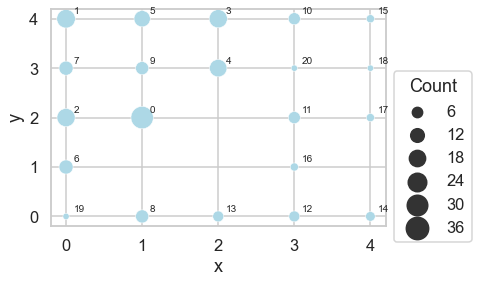

In [20]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')
cell_df['x'] = [x[0] for x in cell_df.Cell]
cell_df['y'] = [x[1] for x in cell_df.Cell]
ax = sns.scatterplot(x="x",y='y',size="Count",data=cell_df,sizes=(40,500),color="lightblue")
ax.legend(title="Count",loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1)
cell_df.sort_values('Count',ascending=False)
cell_df['ix'] = range(0,len(cell_df))
for x,y,ix in cell_df[['x','y','ix']].values:
    ax.text(x+0.1,y+0.1,ix)    

Write each cluster to an SD file.  To look at the clusters with PyMol, you can do 
<pre>
pymol 5RS7_aligned.pdb som_cluster*.sdf
</pre>
Then, in PyMol, execute these commands
<pre>
zoom all
set all_states,on

In [21]:
# delete any files named som_cluster*.sdf
for filename in glob("som_cluster*.sdf"):
    os.unlink(filename)

# write each cluster as an SDF
for i,x in enumerate(lig_df.cell.value_counts().index):
    cluster_df = lig_df.query("cell == @x")
    filename = f"som_cluster_{i:03d}.sdf"
    print(filename, x, cluster_df.shape[0])
    PandasTools.WriteSDF(cluster_df,filename,properties=["Name","Sequence"])

som_cluster_000.sdf (1, 2) 36
som_cluster_001.sdf (0, 4) 24
som_cluster_002.sdf (0, 2) 23
som_cluster_003.sdf (2, 4) 23
som_cluster_004.sdf (2, 3) 21
som_cluster_005.sdf (1, 4) 18
som_cluster_006.sdf (0, 1) 13
som_cluster_007.sdf (0, 3) 13
som_cluster_008.sdf (1, 0) 11
som_cluster_009.sdf (1, 3) 11
som_cluster_010.sdf (3, 4) 9
som_cluster_011.sdf (3, 2) 9
som_cluster_012.sdf (3, 0) 7
som_cluster_013.sdf (2, 0) 7
som_cluster_014.sdf (4, 0) 5
som_cluster_015.sdf (4, 4) 3
som_cluster_016.sdf (3, 1) 3
som_cluster_017.sdf (4, 2) 3
som_cluster_018.sdf (4, 3) 1
som_cluster_019.sdf (0, 0) 1
som_cluster_020.sdf (3, 3) 1


## 5. (Extra) Clustering with HDBSCAN

I was reading the post [Geographic Clustering with HDBSCAN](https://towardsdatascience.com/geographic-clustering-with-hdbscan-ef8cb0ed6051) by João Paulo Figueira and though I'd give the approach a try using this dataset.  After all, this data is sort of geographic, right?  Note that number of clusters can be controlled using the parameter **min_cluster_size** in HBDBScan.  Setting this value to a small number gives lots of smaller clusters.  Setting it to a larger value gives a smaller number of large cluster.  Singletons are in cluster -1. 

In [ ]:
from hdbscan import HDBSCAN

In [ ]:
clusterer = HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(X)

In [ ]:
lig_df['hdbscan'] = clusterer.labels_

In [ ]:
lig_df.hdbscan.value_counts()

In [ ]:
# delete any files named cluster*.sdf
for filename in glob("hdb_cluster*.sdf"):
    os.unlink(filename)

# write each cluster as an SDF
for i,x in enumerate(lig_df.hdbscan.value_counts().index):
    cluster_df = lig_df.query("hdbscan == @x")
    filename = f"hdb_cluster_{i:03d}.sdf"
    print(filename, x, cluster_df.shape[0])
    PandasTools.WriteSDF(cluster_df,filename,properties=["Name","Sequence"])

## Acknowledgments
I'd like to thank Stefan Gahbauer, Brian Shoichet, Jaime Fraser, and Galen Correy for help with the data. 
Also, big thanks to James Krieger and She Zhang for help with Prody. 